## Generate  Fashion MNIST

In [1]:
import os
import glob
import time

import PIL
import imageio
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
from IPython import display
import matplotlib.pyplot as plt
%matplotlib inline

print("tensorflow", tf.__version__)

tensorflow 2.4.1


## load data

In [2]:
fashion_mnist = tf.keras.datasets.fashion_mnist

(train_x, _), (test_x, _) = fashion_mnist.load_data()

4423680/4422102 [==============================] - 0s 0us/step


In [3]:
print("max pixel:", train_x.max())
print("min pixel:", train_x.min())

max pixel: 255
min pixel: 0


In [4]:
train_x.shape

(60000, 28, 28)

In [5]:
train_x = train_x.reshape(train_x.shape[0], 28, 28, 1).astype('float32')
train_x.shape

(60000, 28, 28, 1)

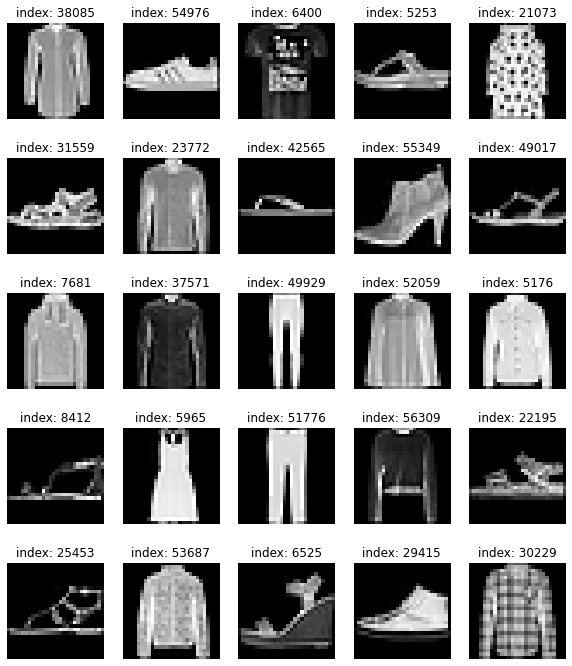

In [6]:
plt.figure(figsize=(10, 12))

for i in range(25):
    plt.subplot(5, 5, i+1)
    random_index = np.random.randint(1, 60000)
    plt.imshow(train_x[random_index].reshape(28, 28), cmap='gray')
    plt.title(f'index: {random_index}')
    plt.axis('off')
plt.show()

## Create Dataset

In [7]:
BUFFER_SIZE = 60000
BATCH_SIZE = 256

In [8]:
train_dataset = tf.data.Dataset.from_tensor_slices(train_x).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

## Create Generator

In [9]:
def make_generator_model():

    # Start
    model = tf.keras.Sequential()

    # First: Dense layer
    model.add(layers.Dense(7*7*256, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    # Second: Reshape layer
    model.add(layers.Reshape((7, 7, 256)))

    # Third: Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(128, kernel_size=(5, 5), strides=(1, 1), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    # Fourth: Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(64, kernel_size=(5, 5), strides=(2, 2), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    # Fifth: Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(1, kernel_size=(5, 5), strides=(2, 2), padding='same', use_bias=False, \
                                     activation='tanh'))

    return model

In [10]:
generator = make_generator_model()

generator.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 12544)             1254400   
_________________________________________________________________
batch_normalization (BatchNo (None, 12544)             50176     
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 12544)             0         
_________________________________________________________________
reshape (Reshape)            (None, 7, 7, 256)         0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 7, 7, 128)         819200    
_________________________________________________________________
batch_normalization_1 (Batch (None, 7, 7, 128)         512       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 7, 7, 128)         0

# Create Latent Vector

In [11]:
noise = tf.random.normal([1, 100])

In [12]:
generated_image = generator(noise, training=False)
generated_image.shape

TensorShape([1, 28, 28, 1])

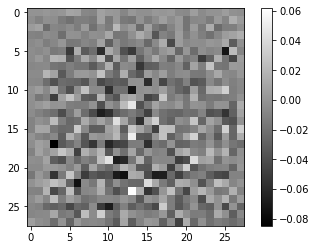

In [13]:
plt.imshow(generated_image[0, :, :, 0], cmap='gray')
plt.colorbar()
plt.show()

# Create Discriminator

In [14]:
def make_discriminator_model():

    # Start
    model = tf.keras.Sequential()

    # First: Conv2D Layer
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=[28, 28, 1]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    # Second: Conv2D Layer
    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    # Third: Flatten Layer
    model.add(layers.Flatten())

    # Fourth: Dense Layer
    model.add(layers.Dense(1))

    return model

In [15]:
discriminator = make_discriminator_model()

discriminator.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 14, 14, 64)        1664      
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 14, 14, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 7, 7, 128)         204928    
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 7, 7, 128)         0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 7, 7, 128)         0         
_________________________________________________________________
flatten (Flatten)            (None, 6272)             

In [16]:
decision = discriminator(generated_image, training=False)
decision

<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[0.00108412]], dtype=float32)>

# Loss Functions
fake_output = D(fake_image)


real_output = D(real_image)

### Cross Entropy

In [17]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

### Generator Loss

In [18]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output) 

### Discriminator Loss

In [19]:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

# Evaluation

### Accuracy

In [20]:
def discriminator_accuracy(real_output, fake_output):
    real_accuracy = tf.reduce_mean(tf.cast(tf.math.greater_equal(real_output, tf.constant([0.5])), tf.float32))
    fake_accuracy = tf.reduce_mean(tf.cast(tf.math.less(fake_output, tf.constant([0.5])), tf.float32))
    return real_accuracy, fake_accuracy

### Optimizer

In [21]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

### Seed Noise

In [22]:
noise_dim = 100
num_examples_to_generate = 16

seed = tf.random.normal([num_examples_to_generate, noise_dim])
seed.shape

TensorShape([16, 100])

# Train Tracking

In [23]:
@tf.function
def train_step(images):  #(1) 입력데이터
    noise = tf.random.normal([BATCH_SIZE, noise_dim])  #(2) 생성자 입력 노이즈

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:  #(3) tf.GradientTape() 오픈
        generated_images = generator(noise, training=True)  #(4) generated_images 생성

        #(5) discriminator 판별
        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        #(6) loss 계산
        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

        #(7) accuracy 계산
        real_accuracy, fake_accuracy = discriminator_accuracy(real_output, fake_output) 
    
    #(8) gradient 계산
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    #(9) 모델 학습
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    return gen_loss, disc_loss, real_accuracy, fake_accuracy  #(10) 리턴값

In [108]:
def generate_and_save_images(model, epoch, it, sample_seeds):

    predictions = model(sample_seeds, training=False)

    fig = plt.figure(figsize=(4, 4))
    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i+1)
        plt.imshow(predictions[i, :, :, 0], cmap='gray')
        plt.axis('off')
    
    try : 
        plt.savefig('{}/aiffel/dcgan_newimage/fashion/generated_samples/sample_epoch_{:04d}_iter_{:03d}.png'.format(os.getenv('HOME'), epoch, it))
    finally:
        plt.show()

In [25]:
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15, 6    # matlab 차트의 기본 크기를 15,6으로 지정해 줍니다.

def draw_train_history(history, epoch):
    # summarize history for loss  
    plt.subplot(211)  
    plt.plot(history['gen_loss'])  
    plt.plot(history['disc_loss'])  
    plt.title('model loss')  
    plt.ylabel('loss')  
    plt.xlabel('batch iters')  
    plt.legend(['gen_loss', 'disc_loss'], loc='upper left')  

    # summarize history for accuracy  
    plt.subplot(212)  
    plt.plot(history['fake_accuracy'])  
    plt.plot(history['real_accuracy'])  
    plt.title('discriminator accuracy')  
    plt.ylabel('accuracy')  
    plt.xlabel('batch iters')  
    plt.legend(['fake_accuracy', 'real_accuracy'], loc='upper left')  
    
    # training_history 디렉토리에 epoch별로 그래프를 이미지 파일로 저장합니다.
    plt.savefig('{}/aiffel/dcgan_newimage/fashion/training_history/train_history_{:04d}.png'
                    .format(os.getenv('HOME'), epoch))
    plt.show()

### Checkpoint

In [26]:
checkpoint_dir = os.getenv('HOME')+'/aiffel/dcgan_newimage/fashion/training_checkpoints'

checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

# Training

In [27]:
def train(dataset, epochs, save_every):
    start = time.time()
    history = {'gen_loss':[], 'disc_loss':[], 'real_accuracy':[], 'fake_accuracy':[]}

    for epoch in range(epochs):
        epoch_start = time.time()
        for it, image_batch in enumerate(dataset):
            gen_loss, disc_loss, real_accuracy, fake_accuracy = train_step(image_batch)
            history['gen_loss'].append(gen_loss)
            history['disc_loss'].append(disc_loss)
            history['real_accuracy'].append(real_accuracy)
            history['fake_accuracy'].append(fake_accuracy)

            if it % 50 == 0:
                display.clear_output(wait=True)
                generate_and_save_images(generator, epoch+1, it+1, seed)
                print('Epoch {} | iter {}'.format(epoch+1, it+1))
                print('Time for epoch {} : {} sec'.format(epoch+1, int(time.time()-epoch_start)))

        if (epoch + 1) % save_every == 0:
            checkpoint.save(file_prefix=checkpoint_prefix)

        display.clear_output(wait=True)
        generate_and_save_images(generator, epochs, it, seed)
        print('Time for training : {} sec'.format(int(time.time()-start)))

        draw_train_history(history, epoch)

In [28]:
save_every = 5
EPOCHS = 50

# 사용가능한 GPU 디바이스 확인
tf.config.list_physical_devices("GPU")

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

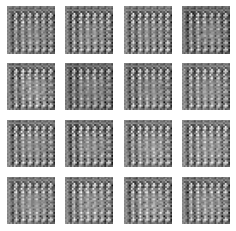

Epoch 1 | iter 51
Time for epoch 1 : 13 sec


KeyboardInterrupt: 

In [29]:
%%time
train(train_dataset, EPOCHS, save_every)

# 학습과정의 loss, accuracy 그래프 이미지 파일이 ~/aiffel/dcgan_newimage/fashion/training_history 경로에 생성되고 있으니
# 진행 과정을 수시로 확인해 보시길 권합니다.

In [30]:
anim_file = os.getenv('HOME')+'/aiffel/dcgan_newimage/fashion/fashion_mnist_dcgan.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
    filenames = glob.glob('{}/aiffel/dcgan_newimage/fashion/generated_samples/sample*.png'.format(os.getenv('HOME')))
    filenames = sorted(filenames)
    last = -1
    for i, filename in enumerate(filenames):
        frame = 2*(i**0.5)
        if round(frame) > round(last):
            last = frame
        else:
            continue
        image = imageio.imread(filename)
        writer.append_data(image)
    image = imageio.imread(filename)
    writer.append_data(image)

!ls -l ~/aiffel/dcgan_newimage/fashion/fashion_mnist_dcgan.gif

-rw-r--r-- 1 root root 1348576 Sep  2 00:55 /aiffel/aiffel/dcgan_newimage/fashion/fashion_mnist_dcgan.gif


# Project

CIFAR-100을 사용하여 generative model을 학습해봅니다.

## load data

In [4]:
cifar10 = tf.keras.datasets.cifar10

(train_x, _), (test_x, _) = cifar10.load_data()

train_x.shape

170500096/170498071 [==============================] - 3s 0us/step


(50000, 32, 32, 3)

## Preprocess data

NHWC 형태로 잘 구성되어 있으므로, 표준화를 진행합니다.

In [5]:
print(f"최대치: {train_x.max()}\n최소치: {train_x.min()}")

최대치: 255
최소치: 0


In [6]:
train_x = 2 * (train_x / train_x.max()) -1  

In [7]:
print(f"최대치: {train_x.max()}\n최소치: {train_x.min()}")

최대치: 1.0
최소치: -1.0


## Create dataset

In [8]:
BUFFER_SIZE = 100000  # data 의 크기보다 크게 설정
BATCH_SIZE = 512

In [9]:
train_dataset = tf.data.Dataset.from_tensor_slices(train_x).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

## Create Generator

In [60]:
def make_generator_model():

    # Start
    model = tf.keras.Sequential()

    # First: Dense layer 
    model.add(layers.Dense(8*8*256, use_bias=False, input_shape=(144,))) # CNN에 넣기 좋은 형태로 변화
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    # Second: Reshape layer
    model.add(layers.Reshape((8, 8, 256)))  # 32 / 2 ** 2 
    
    ####
    # Upsampling
    ####
    
    # Third: Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(128, kernel_size=(5, 5), strides=(1, 1), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    # Fourth: Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(64, kernel_size=(5, 5), strides=(2, 2), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    # Fifth: Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(3, kernel_size=(5, 5), strides=(2, 2), padding='same', use_bias=False, \
                                     activation='tanh'))  # 왜 hyperbolic tan?

    return model

In [61]:
generator = make_generator_model()

generator.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 16384)             2359296   
_________________________________________________________________
batch_normalization_6 (Batch (None, 16384)             65536     
_________________________________________________________________
leaky_re_lu_10 (LeakyReLU)   (None, 16384)             0         
_________________________________________________________________
reshape_2 (Reshape)          (None, 8, 8, 256)         0         
_________________________________________________________________
conv2d_transpose_6 (Conv2DTr (None, 8, 8, 128)         819200    
_________________________________________________________________
batch_normalization_7 (Batch (None, 8, 8, 128)         512       
_________________________________________________________________
leaky_re_lu_11 (LeakyReLU)   (None, 8, 8, 128)        

# Create Latent Vector

In [62]:
noise = tf.random.normal([1, 144])  # (N x D)

In [63]:
noise

<tf.Tensor: shape=(1, 144), dtype=float32, numpy=
array([[-0.3518135 , -0.35598436, -0.01562965, -1.3925655 , -1.2887613 ,
        -0.37721774, -0.31756642, -0.20709145, -0.21121298, -1.9883097 ,
        -0.9768401 , -1.2781817 , -0.20394836, -0.7516821 ,  1.1987927 ,
         0.4604109 , -0.19970271, -0.49588603, -1.2291054 , -0.99148834,
         0.5033855 , -1.1653248 ,  0.14655493, -1.7032433 , -0.33825144,
         1.700137  , -1.0493695 ,  0.4393588 ,  1.5327109 , -0.7116111 ,
         0.6850976 , -1.2228    ,  2.101093  ,  2.5361857 , -0.55056334,
        -0.23366441, -0.06620333,  1.6158161 , -0.87236947, -0.24479836,
        -0.8222177 ,  0.08972502,  0.3996501 ,  0.43502083, -0.19609338,
         0.47338513, -2.100755  ,  1.0655177 ,  1.836943  , -0.18997572,
        -0.18545644, -0.08973444, -1.872394  ,  0.40122843,  0.4976122 ,
        -0.22271447,  1.0682615 , -2.218308  , -0.07051498, -0.1678257 ,
         0.4255237 , -0.3865219 , -0.4664041 , -1.6280127 ,  0.71534425,
 

In [64]:
generated_image = generator(noise, training=False)
generated_image.shape

TensorShape([1, 32, 32, 3])

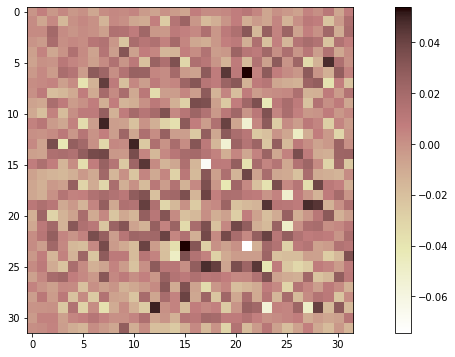

In [74]:
plt.imshow(generated_image[0, :, :, 0], cmap='pink_r')  #  ?
plt.colorbar()
plt.show()

# Create Discriminator

In [66]:
def make_discriminator_model():

    # Start
    model = tf.keras.Sequential()
    
    
    ####
    # Downsampling
    ####
    
    
    # First: Conv2D Layer
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=[32, 32, 3]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    # Second: Conv2D Layer
    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    # Third: Flatten Layer
    model.add(layers.Flatten())

    # Fourth: Dense Layer
    model.add(layers.Dense(1))

    return model

In [67]:
discriminator = make_discriminator_model()

discriminator.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 16, 16, 64)        4864      
_________________________________________________________________
leaky_re_lu_13 (LeakyReLU)   (None, 16, 16, 64)        0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 8, 8, 128)         204928    
_________________________________________________________________
leaky_re_lu_14 (LeakyReLU)   (None, 8, 8, 128)         0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 8, 8, 128)         0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 8192)             

In [68]:
decision = discriminator(generated_image, training=False)
decision

<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[0.00048891]], dtype=float32)>

# Evaluation

### Accuracy

In [94]:
def discriminator_accuracy(real_output, fake_output):
    real_accuracy = tf.reduce_mean(tf.cast(tf.math.greater_equal(real_output, tf.constant([0.5])), tf.float32))
    fake_accuracy = tf.reduce_mean(tf.cast(tf.math.less(fake_output, tf.constant([0.5])), tf.float32))
    return real_accuracy, fake_accuracy

### Optimizer

In [95]:
generator_optimizer = tf.keras.optimizers.Adam(3e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(3e-4)

### Seed Noise

In [10]:
noise_dim = 144
num_examples_to_generate = 25

seed = tf.random.normal([num_examples_to_generate, noise_dim])
seed.shape

TensorShape([25, 144])

# Train Tracking

In [97]:
from os.path import join

In [130]:
DIR_PATH = join(os.getenv('HOME'), '/aiffel/aiffel/dcgan_newimage/CIFAR/')
DIR_PATH

'/aiffel/aiffel/dcgan_newimage/CIFAR/'

In [172]:
@tf.function
def train_step(images):  #(1) 입력데이터
    noise = tf.random.normal([BATCH_SIZE, noise_dim])  #(2) 생성자 입력 노이즈

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:  #(3) tf.GradientTape() 오픈
        generated_images = generator(noise, training=True)  #(4) generated_images 생성

        #(5) discriminator 판별
        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        #(6) loss 계산
        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

        #(7) accuracy 계산
        real_accuracy, fake_accuracy = discriminator_accuracy(real_output, fake_output) 
    
    #(8) gradient 계산
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    #(9) 모델 학습
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    return gen_loss, disc_loss, real_accuracy, fake_accuracy  #(10) 리턴값

In [132]:
def generate_and_save_images(model, epoch, it, sample_seeds):

    predictions = model(sample_seeds, training=False)
    fig = plt.figure(figsize=(5, 5))
    for i in range(predictions.shape[0]):  # RGB로
        plt.subplot(5, 5, i+1)
        
        # [-1, 1] -> [0, 1]  x |->: (x+1) / 2 
        
        plt.imshow((predictions[i, :, :, :]+1)/2)
        plt.axis('off')
    
    try : 
        plt.savefig('{}generated_samples/sample_epoch_{:04d}_iter_{:03d}.png'.format(DIR_PATH, epoch, it))
    finally:
        plt.show()

In [133]:
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15, 6    # matlab 차트의 기본 크기를 15,6으로 지정해 줍니다.

def draw_train_history(history, epoch):
    # summarize history for loss  
    plt.subplot(211)  
    plt.plot(history['gen_loss'])  
    plt.plot(history['disc_loss'])  
    plt.title('model loss')  
    plt.ylabel('loss')  
    plt.xlabel('batch iters')  
    plt.legend(['gen_loss', 'disc_loss'], loc='upper left')  

    # summarize history for accuracy  
    plt.subplot(212)  
    plt.plot(history['fake_accuracy'])  
    plt.plot(history['real_accuracy'])  
    plt.title('discriminator accuracy')  
    plt.ylabel('accuracy')  
    plt.xlabel('batch iters')  
    plt.legend(['fake_accuracy', 'real_accuracy'], loc='upper left')  
    
    # training_history 디렉토리에 epoch별로 그래프를 이미지 파일로 저장합니다.
    plt.savefig('{}training_history/train_history_{:04d}.png'
                    .format(DIR_PATH, epoch))
    plt.show()

### Checkpoint

In [134]:
checkpoint_dir = join(DIR_PATH, '/training_checkpoints')

checkpoint_prefix = join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

# Training

In [135]:
def train(dataset, epochs, save_every):
    start = time.time()
    history = {'gen_loss':[], 'disc_loss':[], 'real_accuracy':[], 'fake_accuracy':[]}

    for epoch in range(epochs):
        epoch_start = time.time()
        for it, image_batch in enumerate(dataset):
            gen_loss, disc_loss, real_accuracy, fake_accuracy = train_step(image_batch)
            history['gen_loss'].append(gen_loss)
            history['disc_loss'].append(disc_loss)
            history['real_accuracy'].append(real_accuracy)
            history['fake_accuracy'].append(fake_accuracy)

            if it % 50 == 0:
                display.clear_output(wait=True)
                generate_and_save_images(generator, epoch+1, it+1, seed)
                print('Epoch {} | iter {}'.format(epoch+1, it+1))
                print('Time for epoch {} : {} sec'.format(epoch+1, int(time.time()-epoch_start)))

        if (epoch + 1) % save_every == 0:
            checkpoint.save(file_prefix=checkpoint_prefix)

        display.clear_output(wait=True)
        generate_and_save_images(generator, epochs, it, seed)
        print('Time for training : {} sec'.format(int(time.time()-start)))

        draw_train_history(history, epoch)

In [136]:
save_every = 5
EPOCHS = 50

# 사용가능한 GPU 디바이스 확인
tf.config.list_physical_devices("GPU")

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

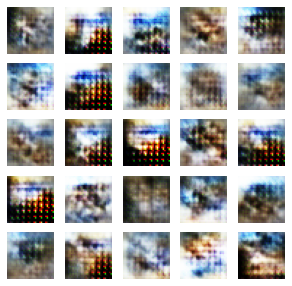

Time for training : 1458 sec


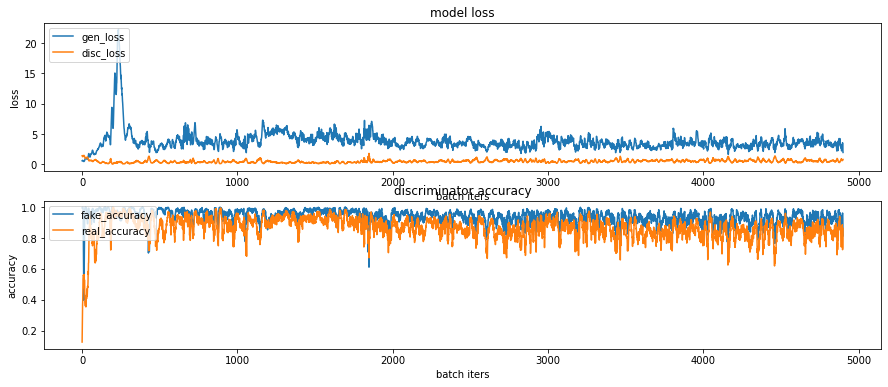

CPU times: user 24min 15s, sys: 20.9 s, total: 24min 36s
Wall time: 24min 18s


In [137]:
%%time
train(train_dataset, EPOCHS, save_every)

# 학습과정의 loss, accuracy 그래프 이미지 파일이 ~/aiffel/dcgan_newimage/CIFAR/training_history 경로에 생성되고 있으니
# 진행 과정을 수시로 확인해 보시길 권합니다.

## 성능이 매우 나쁘다

In [140]:
anim_file = join(DIR_PATH, 'cifar_dcgan.gif')

with imageio.get_writer(anim_file, mode='I') as writer:
    filenames = glob.glob('{}generated_samples/sample*.png'.format(DIR_PATH))
    filenames = sorted(filenames)
    last = -1
    for i, filename in enumerate(filenames):
        frame = 2*(i**0.5)
        if round(frame) > round(last):
            last = frame
        else:
            continue
        image = imageio.imread(filename)
        writer.append_data(image)
    image = imageio.imread(filename)
    writer.append_data(image)

!ls -l ~/aiffel/dcgan_newimage/CIFAR/cifar_dcgan.gif

-rw-r--r-- 1 root root 1440734 Sep  2 02:32 /aiffel/aiffel/dcgan_newimage/CIFAR/cifar_dcgan.gif


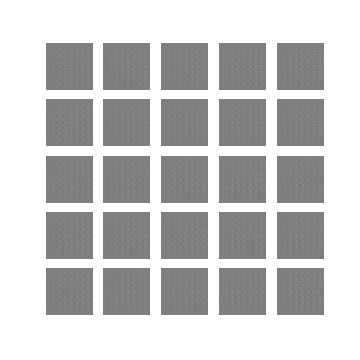

## 개선방안
---
1. Upsampling과 Downsampling을 한 단계씩 더 추가한다. [참고링크](https://kangbk0120.github.io/articles/2017-08/dcgan-pytorch)

In [145]:
def make_generator_model_better():

    # Start
    model = tf.keras.Sequential()

    # First: Dense layer 
    model.add(layers.Dense(4*4*(64*4), use_bias=False, input_shape=(144,))) # CNN에 넣기 좋은 형태로 변화
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    # Second: Reshape layer
    model.add(layers.Reshape((4, 4, 64*4)))  # 32 / 2 ** 3 
    
    ####
    # Upsampling
    ####
    
    # Third: Conv2DTranspose layer  (8, 8, 64*2)
    model.add(layers.Conv2DTranspose(64*2, kernel_size=(4, 4), strides=(2, 2), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    # Fourth: Conv2DTranspose layer  (16, 16, 64)
    model.add(layers.Conv2DTranspose(64, kernel_size=(4, 4), strides=(2, 2), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    
    # Fifth: Conv2DTranspose layer   (32, 32, 3)
    model.add(layers.Conv2DTranspose(3, kernel_size=(4, 4), strides=(2, 2), padding='same', use_bias=False, \
                                     activation='tanh'))  # 왜 hyperbolic tan?

    return model

In [146]:
def make_discriminator_model_better():

    # Start
    model = tf.keras.Sequential()
    
    
    ####
    # Downsampling
    ####
    
    
    # First: Conv2D Layer  (16, 16, 64)
    model.add(layers.Conv2D(64, (4, 4), strides=(2, 2), padding='same', input_shape=[32, 32, 3]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    # Second: Conv2D Layer    (8, 8, 64*2)
    model.add(layers.Conv2D(64*2, (4, 4), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))
    
    #  Third: Conv2D Layer    (4, 4, 64*4)
    model.add(layers.Conv2D(64*4, (4, 4), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    # Third: Flatten Layer
    model.add(layers.Flatten())

    # Fourth: Dense Layer
    model.add(layers.Dense(1))

    return model

In [147]:
generator = make_generator_model_better()

generator.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_8 (Dense)              (None, 4096)              589824    
_________________________________________________________________
batch_normalization_13 (Batc (None, 4096)              16384     
_________________________________________________________________
leaky_re_lu_19 (LeakyReLU)   (None, 4096)              0         
_________________________________________________________________
reshape_5 (Reshape)          (None, 4, 4, 256)         0         
_________________________________________________________________
conv2d_transpose_12 (Conv2DT (None, 8, 8, 128)         524288    
_________________________________________________________________
batch_normalization_14 (Batc (None, 8, 8, 128)         512       
_________________________________________________________________
leaky_re_lu_20 (LeakyReLU)   (None, 8, 8, 128)        

In [148]:
discriminator = make_discriminator_model_better()

discriminator.summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 16, 16, 64)        3136      
_________________________________________________________________
leaky_re_lu_22 (LeakyReLU)   (None, 16, 16, 64)        0         
_________________________________________________________________
dropout_6 (Dropout)          (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 8, 8, 128)         131200    
_________________________________________________________________
leaky_re_lu_23 (LeakyReLU)   (None, 8, 8, 128)         0         
_________________________________________________________________
dropout_7 (Dropout)          (None, 8, 8, 128)         0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 4, 4, 256)        

In [149]:
DIR_PATH2 = join(os.getenv('HOME'), '/aiffel/aiffel/dcgan_newimage/CIFAR_2/')
DIR_PATH2

'/aiffel/aiffel/dcgan_newimage/CIFAR_2/'

In [34]:
def generate_and_save_images(model, epoch, it, sample_seeds, path=DIR_PATH3):

    predictions = model(sample_seeds, training=False)
    fig = plt.figure(figsize=(5, 5))
    for i in range(predictions.shape[0]):  # RGB로
        plt.subplot(5, 5, i+1)
        
        # [-1, 1] -> [0, 1]  x |->: (x+1) / 2 
        
        plt.imshow((predictions[i, :, :, :]+1)/2)
        plt.axis('off')
    
    try : 
        plt.savefig('{}generated_samples/sample_epoch_{:04d}_iter_{:03d}.png'.format(path, epoch, it))
    finally:
        plt.show()

In [35]:
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15, 6    # matlab 차트의 기본 크기를 15,6으로 지정해 줍니다.

def draw_train_history(history, epoch, path=DIR_PATH3):
    # summarize history for loss  
    plt.subplot(211)  
    plt.plot(history['gen_loss'])  
    plt.plot(history['disc_loss'])  
    plt.title('model loss')  
    plt.ylabel('loss')  
    plt.xlabel('batch iters')  
    plt.legend(['gen_loss', 'disc_loss'], loc='upper left')  

    # summarize history for accuracy  
    plt.subplot(212)  
    plt.plot(history['fake_accuracy'])  
    plt.plot(history['real_accuracy'])  
    plt.title('discriminator accuracy')  
    plt.ylabel('accuracy')  
    plt.xlabel('batch iters')  
    plt.legend(['fake_accuracy', 'real_accuracy'], loc='upper left')  
    
    # training_history 디렉토리에 epoch별로 그래프를 이미지 파일로 저장합니다.
    plt.savefig('{}training_history/train_history_{:04d}.png'
                    .format(path, epoch))
    plt.show()

### Checkpoint

In [54]:
# checkpoint_dir = join(DIR_PATH, '/training_checkpoints')

# checkpoint_prefix = join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

# Training

In [193]:
def train(dataset, epochs, iters, save_every, path):
    start = time.time()
    history = {'gen_loss':[], 'disc_loss':[], 'real_accuracy':[], 'fake_accuracy':[]}

    for epoch in range(epochs):
        epoch_start = time.time()
        for it, image_batch in enumerate(dataset):
            gen_loss, disc_loss, real_accuracy, fake_accuracy = train_step(image_batch)
            history['gen_loss'].append(gen_loss)
            history['disc_loss'].append(disc_loss)
            history['real_accuracy'].append(real_accuracy)
            history['fake_accuracy'].append(fake_accuracy)

            if it % iters== 0:
                display.clear_output(wait=True)
                generate_and_save_images(generator, epoch+1, it+1, seed, path)
                print('Epoch {} | iter {}'.format(epoch+1, it+1))
                print('Time for epoch {} : {} sec'.format(epoch+1, int(time.time()-epoch_start)))

        if (epoch + 1) % save_every == 0:
            checkpoint_dir = join(path, 'training_checkpoints')
            checkpoint_prefix = join(checkpoint_dir, "ckpt")
            checkpoint.save(file_prefix=checkpoint_prefix)

        display.clear_output(wait=True)
        generate_and_save_images(generator, epochs, it, seed)
        print('Time for training : {} sec'.format(int(time.time()-start)))

        draw_train_history(history, epoch, path)

In [154]:
save_every = 5
EPOCHS = 50
ITERS = 100

# 사용가능한 GPU 디바이스 확인
tf.config.list_physical_devices("GPU")

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

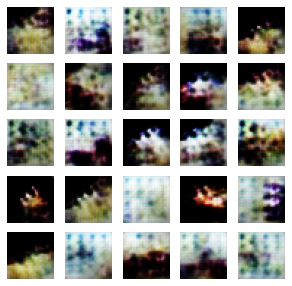

Epoch 40 | iter 1
Time for epoch 40 : 2 sec


KeyboardInterrupt: 

In [157]:
%%time
train(train_dataset, EPOCHS, ITERS,save_every)

# 학습과정의 loss, accuracy 그래프 이미지 파일이 ~/aiffel/dcgan_newimage/CIFAR_2/training_history 경로에 생성되고 있으니
# 진행 과정을 수시로 확인해 보시길 권합니다.

## Trial 3. dropout을 줄입니다.

In [185]:
!rm -rf ~/aiffel/dcgan_newimage/CIFAR_3

In [186]:
!mkdir -p ~/aiffel/dcgan_newimage/CIFAR_3/generated_samples
!mkdir -p ~/aiffel/dcgan_newimage/CIFAR_3/training_checkpoints
!mkdir -p ~/aiffel/dcgan_newimage/CIFAR_3/training_history

In [187]:
DIR_PATH3 = join(os.getenv('HOME'), '/aiffel/aiffel/dcgan_newimage/CIFAR_3/')
DIR_PATH3

'/aiffel/aiffel/dcgan_newimage/CIFAR_3/'

In [188]:
def make_generator_model_better():

    # Start
    model = tf.keras.Sequential()

    # First: Dense layer 
    model.add(layers.Dense(4*4*(64*4), use_bias=False, input_shape=(144,))) # CNN에 넣기 좋은 형태로 변화
    # model.add(layers.BatchNormalization())
    model.add(layers.ReLU())

    # Second: Reshape layer
    model.add(layers.Reshape((4, 4, 64*4)))  # 32 / 2 ** 3 
    
    ####
    # Upsampling
    ####
    
    # Third: Conv2DTranspose layer  (8, 8, 64*2)
    model.add(layers.Conv2DTranspose(64*2, kernel_size=(4, 4), strides=(2, 2), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.ReLU())

    # Fourth: Conv2DTranspose layer  (16, 16, 64)
    model.add(layers.Conv2DTranspose(64, kernel_size=(4, 4), strides=(2, 2), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.ReLU())
    
    # Fifth: Conv2DTranspose layer   (32, 32, 3)
    model.add(layers.Conv2DTranspose(3, kernel_size=(4, 4), strides=(2, 2), padding='same', use_bias=False, \
                                     activation='tanh'))  # 왜 hyperbolic tan?

    return model

In [189]:
def make_discriminator_model_better():

    # Start
    model = tf.keras.Sequential()
    
    
    ####
    # Downsampling
    ####
    
    
    # First: Conv2D Layer  (16, 16, 64)
    model.add(layers.Conv2D(64, (4, 4), strides=(2, 2), padding='same', input_shape=[32, 32, 3]))
    model.add(layers.LeakyReLU(0.2))
    model.add(layers.Dropout(0.05))

    # Second: Conv2D Layer    (8, 8, 64*2)
    model.add(layers.Conv2D(64*2, (4, 4), strides=(2, 2), padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(0.2))
    model.add(layers.Dropout(0.05))
    
    #  Third: Conv2D Layer    (4, 4, 64*4)
    model.add(layers.Conv2D(64*4, (4, 4), strides=(2, 2), padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(0.2))
    model.add(layers.Dropout(0.05))

    # Third: Flatten Layer
    model.add(layers.Conv2D(1, (4, 4), strides=(1, 1), padding='same'))
    model.add(layers.Flatten())

    # Fourth: Dense Layer
    model.add(layers.Dense(1))

    return model

In [190]:
generator = make_generator_model_better()
discriminator = make_discriminator_model_better()

In [191]:
save_every = 5
EPOCHS = 200
ITERS = 100

# 사용가능한 GPU 디바이스 확인
tf.config.list_physical_devices("GPU")

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [192]:
@tf.function
def train_step(images):  #(1) 입력데이터
    noise = tf.random.normal([BATCH_SIZE, noise_dim])  #(2) 생성자 입력 노이즈

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:  #(3) tf.GradientTape() 오픈
        generated_images = generator(noise, training=True)  #(4) generated_images 생성

        #(5) discriminator 판별
        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        #(6) loss 계산
        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

        #(7) accuracy 계산
        real_accuracy, fake_accuracy = discriminator_accuracy(real_output, fake_output) 
    
    #(8) gradient 계산
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    #(9) 모델 학습
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    return gen_loss, disc_loss, real_accuracy, fake_accuracy  #(10) 리턴값

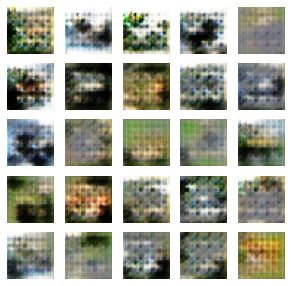

Epoch 61 | iter 1
Time for epoch 61 : 2 sec


KeyboardInterrupt: 

In [194]:
%%time
train(train_dataset, EPOCHS, ITERS, save_every, DIR_PATH3)

# 학습과정의 loss, accuracy 그래프 이미지 파일이 ~/aiffel/dcgan_newimage/CIFAR_2/training_history 경로에 생성되고 있으니
# 진행 과정을 수시로 확인해 보시길 권합니다.

In [195]:
anim_file = join(DIR_PATH3, 'cifar_dcgan.gif')

with imageio.get_writer(anim_file, mode='I') as writer:
    filenames = glob.glob('{}generated_samples/sample*.png'.format(DIR_PATH))
    filenames = sorted(filenames)
    last = -1
    for i, filename in enumerate(filenames):
        frame = 2*(i**0.5)
        if round(frame) > round(last):
            last = frame
        else:
            continue
        image = imageio.imread(filename)
        writer.append_data(image)
    image = imageio.imread(filename)
    writer.append_data(image)

!ls -l ~/aiffel/dcgan_newimage/CIFAR/cifar_dcgan.gif

-rw-r--r-- 1 root root 1440734 Sep  2 02:32 /aiffel/aiffel/dcgan_newimage/CIFAR/cifar_dcgan.gif


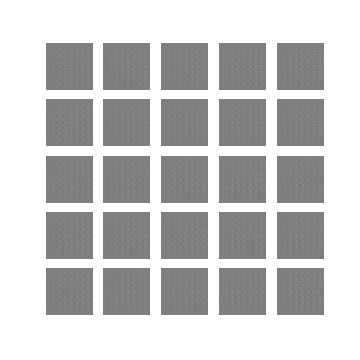

## Trial 4
Discriminator가 너무 빨리 학습해버리고, upsampling 과정에서 격자무늬가 심각하게 발생합니다.
WGAN을 만들어봅니다. 

* 1. Real image 에 대해서는 1, Fake image에 대해서는 -1을 label로 사용합니다.
* 2. 마지막 activation을 linear로 바꿉니다.
* 3. RMSprop을 사용합니다.

# Loss Functions
fake_output = D(fake_image)


real_output = D(real_image)

### Wasserstein Loss
real image의 예측 평균값이 fake image의 예측 평균값보다 높아지게 합니다.

In [368]:
from keras import backend

# implementation of wasserstein loss
def wasserstein_loss(y_true, y_pred):
	return backend.mean(y_true * y_pred)

### Generator Loss

In [11]:
def generator_loss(fake_output):
    gen_loss = -1. * tf.math.reduce_mean(fake_output)
    return gen_loss

### Discriminator Loss

In [12]:
def discriminator_loss(real_output, fake_output, gradient_penalty):
    c_lambda = 10
    loss = tf.math.reduce_mean(fake_output) - tf.math.reduce_mean(real_output) + c_lambda * gradient_penalty
    return loss

# Evaluation

### Optimizer

In [13]:
generator_optimizer = tf.keras.optimizers.RMSprop(5e-5)
discriminator_optimizer = tf.keras.optimizers.RMSprop(5e-5)

In [14]:
!rm -rf ~/aiffel/dcgan_newimage/CIFAR_3

In [15]:
!mkdir -p ~/aiffel/dcgan_newimage/CIFAR_3/generated_samples
!mkdir -p ~/aiffel/dcgan_newimage/CIFAR_3/training_checkpoints
!mkdir -p ~/aiffel/dcgan_newimage/CIFAR_3/training_history

In [17]:
from os.path import join

In [18]:
DIR_PATH3 = join(os.getenv('HOME'), '/aiffel/aiffel/dcgan_newimage/CIFAR_3/')
DIR_PATH3

'/aiffel/aiffel/dcgan_newimage/CIFAR_3/'

In [19]:
def make_generator_model_better():

    # Start
    model = tf.keras.Sequential()

    # First: Dense layer 
    model.add(layers.Dense(4*4*(64*4), use_bias=False, input_shape=(144,))) # CNN에 넣기 좋은 형태로 변화
    # model.add(layers.BatchNormalization())
    model.add(layers.ReLU())

    # Second: Reshape layer
    model.add(layers.Reshape((4, 4, 64*4)))  # 32 / 2 ** 3 
    
    ####
    # Upsampling
    ####
    
    # Third: Conv2DTranspose layer  (8, 8, 64*2)
    model.add(layers.Conv2DTranspose(64*2, kernel_size=(4, 4), strides=(2, 2), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.ReLU())

    # Fourth: Conv2DTranspose layer  (16, 16, 64)
    model.add(layers.Conv2DTranspose(64, kernel_size=(4, 4), strides=(2, 2), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.ReLU())
    
    # Fifth: Conv2DTranspose layer   (32, 32, 3)
    model.add(layers.Conv2DTranspose(3, kernel_size=(4, 4), strides=(2, 2), padding='same', use_bias=False, \
                                     activation='tanh'))  # 왜 hyperbolic tan?

    return model

In [20]:
def make_discriminator_model_better():

    # Start
    model = tf.keras.Sequential()
    
    
    ####
    # Downsampling
    ####
    
    
    # First: Conv2D Layer  (16, 16, 64)
    model.add(layers.Conv2D(64, (4, 4), strides=(2, 2), padding='same', input_shape=[32, 32, 3]))
    model.add(layers.LeakyReLU(0.2))
    model.add(layers.Dropout(0.05))

    # Second: Conv2D Layer    (8, 8, 64*2)
    model.add(layers.Conv2D(64*2, (4, 4), strides=(2, 2), padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(0.2))
    model.add(layers.Dropout(0.05))
    
    #  Third: Conv2D Layer    (4, 4, 64*4)
    model.add(layers.Conv2D(64*4, (4, 4), strides=(2, 2), padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(0.2))
    model.add(layers.Dropout(0.05))

    # Third: Flatten Layer
    model.add(layers.Conv2D(1, (4, 4), strides=(1, 1), padding='same'))
    model.add(layers.Flatten())

    # Fourth: Dense Layer
    model.add(layers.Dense(1))

    return model

In [21]:
generator = make_generator_model_better()
discriminator = make_discriminator_model_better()

In [22]:
generator.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 4096)              589824    
_________________________________________________________________
re_lu (ReLU)                 (None, 4096)              0         
_________________________________________________________________
reshape (Reshape)            (None, 4, 4, 256)         0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 8, 8, 128)         524288    
_________________________________________________________________
batch_normalization (BatchNo (None, 8, 8, 128)         512       
_________________________________________________________________
re_lu_1 (ReLU)               (None, 8, 8, 128)         0         
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 16, 16, 64)        1

In [23]:
discriminator.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 16, 16, 64)        3136      
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 16, 16, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 8, 8, 128)         131200    
_________________________________________________________________
batch_normalization_2 (Batch (None, 8, 8, 128)         512       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 8, 8, 128)         0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 8, 8, 128)        

In [24]:
@tf.function
def gradient_penalty(real, fake, epsilon):
    fake = tf.cast(fake, 'float64')
    real = tf.cast(real, 'float64')
    epsilon = tf.cast(epsilon, 'float64')
    #mixed_images = real * epsilon + fake * (1 - epsilon)
    mixed_images = fake + epsilon * (real - fake)
    with tf.GradientTape() as tape:
        tape.watch(mixed_images) 
        mixed_scores = discriminator(mixed_images)
        

    gradient = tape.gradient(mixed_scores, mixed_images)[0]
    
    gradient_norm = tf.norm(gradient)
    penalty = tf.math.reduce_mean((gradient_norm - 1)**2)
    penalty = tf.cast(penalty, 'float32')
    return penalty

In [25]:
BATCH_SIZE

512

In [26]:
@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    #training discriminator 4 times for each batch
    for i in range(4):

        with tf.GradientTape() as disc_tape:

            generated_images = generator(noise, training=True)

            real_output = discriminator(images, training=True)
            fake_output = discriminator(generated_images, training=True)
            #print(np.shape(real_output))
            #print(np.shape(fake_output))
            epsilon = tf.random.normal([BATCH_SIZE, 1, 1, 3], 0.0, 1.0, dtype=tf.dtypes.float64)
            #print(np.shape(epsilon))
            gp = gradient_penalty(images, generated_images, epsilon)

            disc_loss = discriminator_loss(real_output, fake_output, gp)


        gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
        discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    with tf.GradientTape() as gen_tape:
        generated_images = generator(noise, training=True)
        fake_output = discriminator(generated_images, training=True)
        gen_loss = generator_loss(fake_output)
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    print(gen_loss.shape, disc_loss.shape)
    return gen_loss, disc_loss

In [29]:
save_every = 5
EPOCHS = 500
ITERS = 25

# 사용가능한 GPU 디바이스 확인
tf.config.list_physical_devices("GPU")

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [48]:
def train(dataset, epochs, iters, save_every, path):
    start = time.time()
    history = {'gen_loss':[], 'disc_loss':[]}

    for epoch in range(epochs):
        epoch_start = time.time()
        for it, image_batch in enumerate(dataset):
            if len(image_batch) == BATCH_SIZE:
                gen_loss, disc_loss = train_step(image_batch)
                history['gen_loss'].append(gen_loss)
                history['disc_loss'].append(disc_loss)


                if it % iters== 0:
                    display.clear_output(wait=True)
                    print('Epoch {} | iter {}'.format(epoch+1, it+1))
                    print('Time for epoch {} : {} sec'.format(epoch+1, int(time.time()-epoch_start)))

                    generate_and_save_images(generator, epoch+1, it+1, seed, path)

        if (epoch + 1) % save_every == 0:
            checkpoint_dir = join(path, 'training_checkpoints')
            checkpoint_prefix = join(checkpoint_dir, "ckpt")
            checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)
            checkpoint.save(file_prefix=checkpoint_prefix)

        display.clear_output(wait=True)
        print('Time for training : {} sec'.format(int(time.time()-start)))

        draw_train_history(history, epoch, path)

In [49]:
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15, 6    # matlab 차트의 기본 크기를 15,6으로 지정해 줍니다.

def draw_train_history(history, epoch, path=DIR_PATH3):
    # summarize history for loss  
    plt.subplot(211)  
    plt.plot(history['gen_loss'])  
    plt.plot(history['disc_loss'])  
    plt.title('model loss')  
    plt.ylabel('loss')  
    plt.xlabel('batch iters')  
    plt.legend(['gen_loss', 'disc_loss'], loc='upper left')  
     
    # training_history 디렉토리에 epoch별로 그래프를 이미지 파일로 저장합니다.
    plt.savefig('{}training_history/train_history_{:04d}.png'
                    .format(path, epoch))
    plt.show()

Epoch 31 | iter 1
Time for epoch 31 : 2 sec


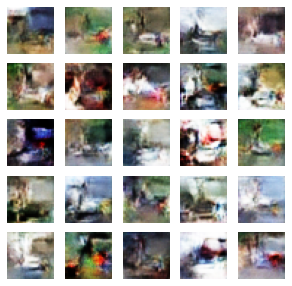

KeyboardInterrupt: 

In [50]:
%%time
train(train_dataset, EPOCHS, 33, save_every, DIR_PATH3)

# 학습과정의 loss, accuracy 그래프 이미지 파일이 ~/aiffel/dcgan_newimage/CIFAR_3training_history 경로에 생성되고 있으니
# 진행 과정을 수시로 확인해 보시길 권합니다.가

In [52]:
anim_file = join(DIR_PATH3, 'cifar_dcgan.gif')

with imageio.get_writer(anim_file, mode='I') as writer:
    filenames = glob.glob('{}generated_samples/sample*.png'.format(DIR_PATH3))
    filenames = sorted(filenames)
    last = -1
    for i, filename in enumerate(filenames):
        frame = 2*(i**0.5)
        if round(frame) > round(last):
            last = frame
        else:
            continue
        image = imageio.imread(filename)
        writer.append_data(image)
    image = imageio.imread(filename)
    writer.append_data(image)

!ls -l ~/aiffel/dcgan_newimage/CIFAR/cifar_dcgan.gif

-rw-r--r-- 1 root root 1440734 Sep  2 02:32 /aiffel/aiffel/dcgan_newimage/CIFAR/cifar_dcgan.gif


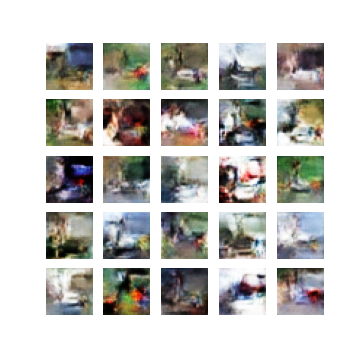

# 회고

1️⃣ 잘한 점:

WGAN의 구조를 필사하고, 효과적인 DCGAN구조를 벤치마크했다
[참고 링크](https://github.com/abhisheksuran/myGAN-tf2.0/blob/master/mnist_WGAN.ipynb)
[참고 링크2](https://kangbk0120.github.io/articles/2017-08/dcgan-pytorch)
에러를 끝까지 포기하지 않고 찾아내서 훈련이 진행되게 하였다

2️⃣ 어려웠던 점:

버전 관리가 매우 어려워서 모델을 새로 돌릴때마다 폴더를 삭제하고 새로 만드는 과정을 반복해야 했다.
너무 느리다. 더 빠르게 돌릴 수 있는 방법이 있을 수 있으나 알지 못한다
어떻게 해야 개선할 수 있는지 전혀 모르겠다

3️⃣ 느낀 점:

GAN은 모델링을 어떻게 하는지가 매우 중요한 것 같다.
